- https://www.suche-postleitzahl.org/downloads
- http://geopandas.org/mapping.html
- https://worldpostalcode.com/germany/berlin
- https://gist.github.com/jbspeakr/4565964
- https://www.r-bloggers.com/case-study-mapping-german-zip-codes-in-r/

# Open Data: Germanz Maps Viz

In this notebook I want to show how to use public available (open) data to create geo visualizations in python. Maps are a great way to communicate information when working with geolocation data. There are many frameworks to plot maps, here I focus on [matplotlib](https://matplotlib.org) and [geopandas](http://geopandas.org) (and give a glimpse of [mplleaflet](https://github.com/jwass/mplleaflet)).

## Prepare Notebook

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

%matplotlib inline

## Get Germany Data 

The main data source for this notebook is [www.suche-postleitzahl.org/downloads](https://www.suche-postleitzahl.org/downloads). Here we download 3 data sets: 

- `plz-gebiete.shp`: shapefile with germany postalcodes polygons.
- `zuordnung_plz_ort.csv`: postal code to city and bundesland mapping.
- `plz_einwohner.csv`: population is assigned to each postcode area.

## Germany Maps

In [2]:
# Make sure you read postal codes as strings, otherwise 
# the postal code 01110 will be parsed as the number 1110. 
plz_shape_df = gpd.read_file('../Data/plz-gebiete.shp', dtype={'plz': str})

plz_shape_df.head()

,plz,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ..."
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ..."
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ..."


The `geometry` column contains the polygons which define the postalcode's shape.

We can use [geopandas mapping tools](http://geopandas.org/mapping.html) to generate the map with the `plot` method.

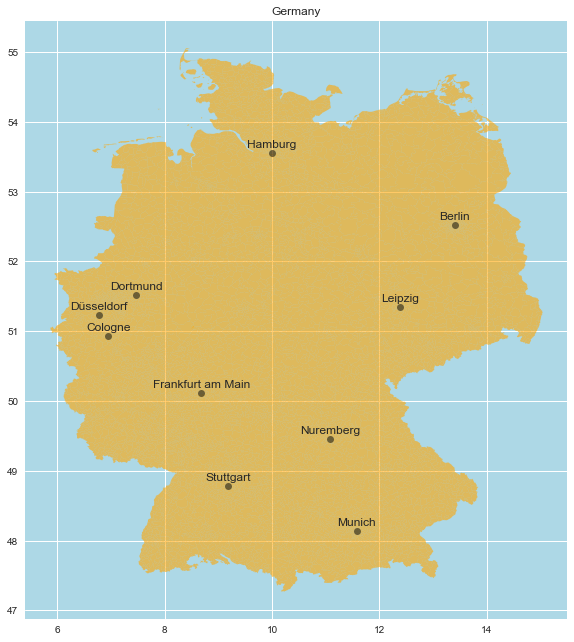

In [24]:
plt.rcParams['figure.figsize'] = [16, 11]

# Get lat and lng of Germany's main cities. 
top_cities = {
    'Berlin': (13.404954, 52.520008), 
    'Cologne': (6.953101, 50.935173),
    'Düsseldorf': (6.782048, 51.227144),
    'Frankfurt am Main': (8.682127, 50.110924),
    'Hamburg': (9.993682, 53.551086),
    'Leipzig': (12.387772, 51.343479),
    'Munich': (11.576124, 48.137154),
    'Dortmund': (7.468554, 51.513400),
    'Stuttgart': (9.181332, 48.777128),
    'Nuremberg': (11.077438, 49.449820),
}

fig, ax = plt.subplots()

plz_shape_df.plot(ax=ax, color='orange', alpha=0.6)

# Plot cities. 
for c in top_cities.keys():
    # Plot city name.
    ax.text(
        x=top_cities[c][0], 
        # Add small shift to avoid overlap with point.
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )
    # Plot city location centroid.
    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )

ax.set(
    title='Germany', 
    aspect=1.3, 
    facecolor='lightblue'
);

### First-Digit-Postalcodes Areas

Next, let us plot different regions corresponding to the first digit of each postalcode.

In [4]:
plz_shape_df = plz_shape_df \
    .assign(first_dig_plz = lambda x: x['plz'].str.slice(start=0, stop=1))

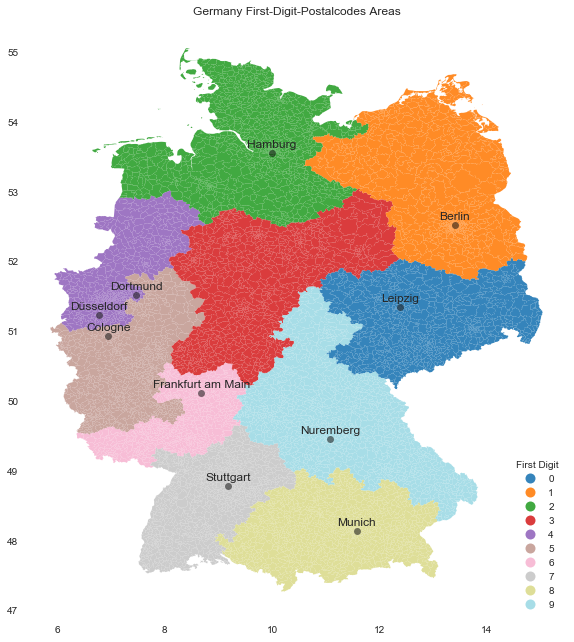

In [5]:
fig, ax = plt.subplots()

plz_shape_df.plot(
    ax=ax, 
    column='first_dig_plz', 
    categorical=True, 
    legend=True, 
    legend_kwds={'title':'First Digit', 'loc':'lower right'},
    cmap='tab20',
    alpha=0.9
)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )

ax.set(
    title='Germany First-Digit-Postalcodes Areas', 
    aspect=1.3,
    facecolor='white'
);

### Bundesland Map

Let us now map each postal code to the corresponding region:

In [6]:
plz_region_df = pd.read_csv(
    '../Data/zuordnung_plz_ort.csv', 
    sep=',', 
    dtype={'plz': str}
)

plz_region_df.drop('osm_id', axis=1, inplace=True)

plz_region_df.head()

,ort,plz,bundesland
0,Aach,78267,Baden-Württemberg
1,Aach,54298,Rheinland-Pfalz
2,Aachen,52062,Nordrhein-Westfalen
3,Aachen,52064,Nordrhein-Westfalen
4,Aachen,52066,Nordrhein-Westfalen


In [7]:
# Merge data.
germany_df = pd.merge(
    left=plz_shape_df, 
    right=plz_region_df, 
    on='plz',
    how='inner'
)

germany_df.drop(['note'], axis=1, inplace=True)

germany_df.head()

,plz,geometry,first_dig_plz,ort,bundesland
0,52538,"POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",5,Gangelt,Nordrhein-Westfalen
1,52538,"POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",5,Selfkant,Nordrhein-Westfalen
2,47559,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...",4,Kranenburg,Nordrhein-Westfalen
3,52525,"POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",5,Heinsberg,Nordrhein-Westfalen
4,52525,"POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",5,Waldfeucht,Nordrhein-Westfalen


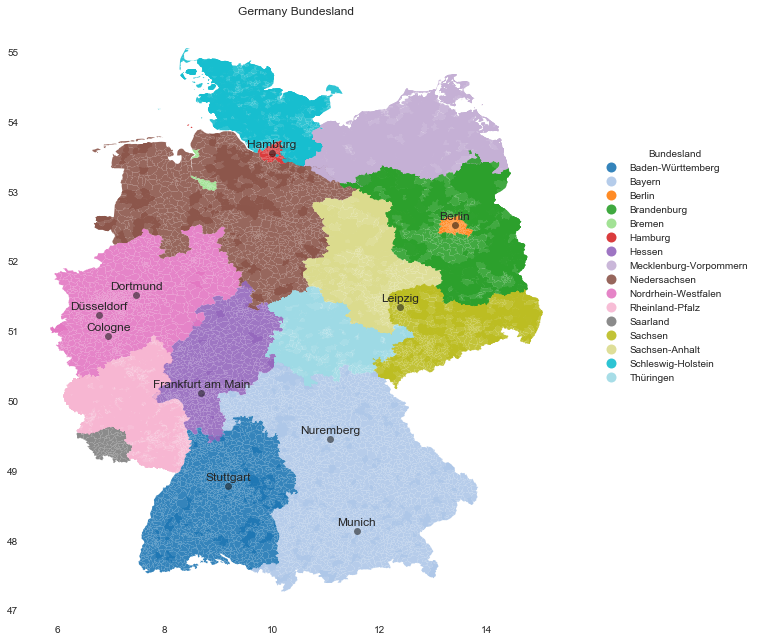

In [8]:
fig, ax = plt.subplots()

germany_df.plot(
    ax=ax, 
    column='bundesland', 
    categorical=True, 
    legend=True, 
    legend_kwds={'title':'Bundesland', 'bbox_to_anchor': (1.35, 0.8)},
    cmap='tab20',
    alpha=0.9
)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )

ax.set(
    title='Germany Bundesland', 
    aspect=1.3, 
    facecolor='white'
);

### Number of Inhabitants

Now we include the number of inhabitants per postalcode:

In [9]:
plz_einwohner_df = pd.read_csv(
    '../Data/plz_einwohner.csv', 
    sep=',', 
    dtype={'plz': str, 'einwohner': int}
)

plz_einwohner_df.head()

,plz,einwohner
0,01067,11957
1,01069,25491
2,01097,14811
3,01099,28021
4,01108,5876


In [10]:
# Merge data.
germany_df = pd.merge(
    left=germany_df, 
    right=plz_einwohner_df, 
    on='plz',
    how='left'
)

germany_df.head()

,plz,geometry,first_dig_plz,ort,bundesland,einwohner
0,52538,"POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",5,Gangelt,Nordrhein-Westfalen,21390
1,52538,"POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",5,Selfkant,Nordrhein-Westfalen,21390
2,47559,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...",4,Kranenburg,Nordrhein-Westfalen,10220
3,52525,"POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",5,Heinsberg,Nordrhein-Westfalen,49737
4,52525,"POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",5,Waldfeucht,Nordrhein-Westfalen,49737


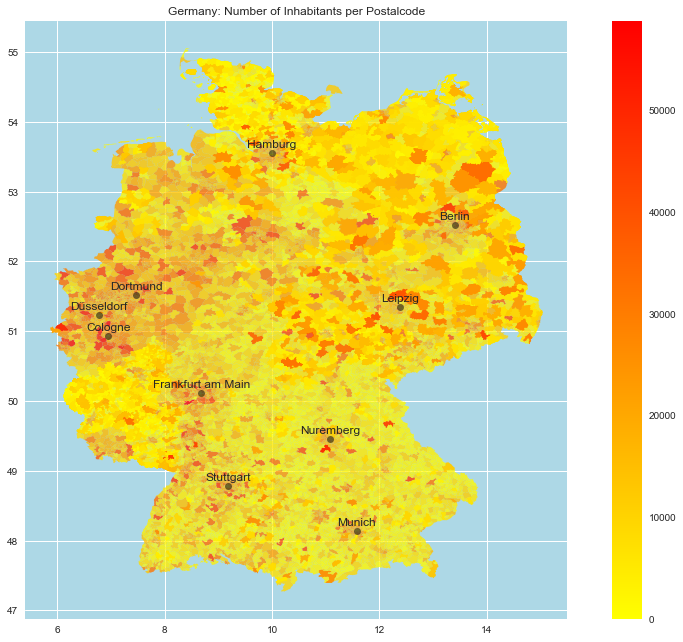

In [11]:
fig, ax = plt.subplots()

germany_df.plot(
    ax=ax, 
    column='einwohner', 
    categorical=False, 
    legend=True, 
    cmap='autumn_r',
    alpha=0.8
)

for c in top_cities.keys():

    ax.text(
        x=top_cities[c][0], 
        y=top_cities[c][1] + 0.08, 
        s=c, 
        fontsize=12,
        ha='center', 
    )

    ax.plot(
        top_cities[c][0], 
        top_cities[c][1], 
        marker='o',
        c='black', 
        alpha=0.5
    )
    
ax.set(
    title='Germany: Number of Inhabitants per Postalcode', 
    aspect=1.3, 
    facecolor='lightblue'
);

## City Maps

We can now filter for cities.

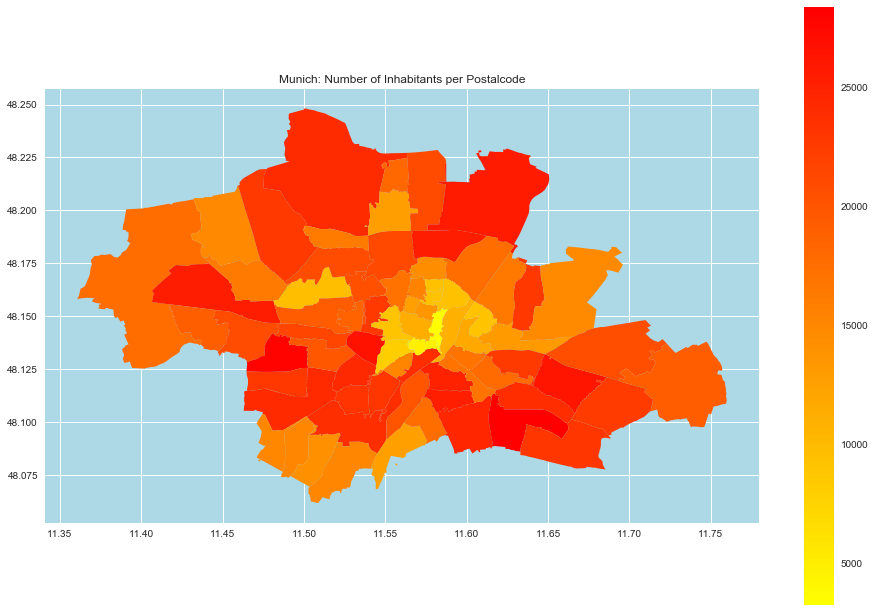

In [12]:
munich_df = germany_df.query('ort == "München"')

fig, ax = plt.subplots()

munich_df.plot(
    ax=ax, 
    column='einwohner', 
    categorical=False, 
    legend=True, 
    cmap='autumn_r',
)

ax.set(
    title='Munich: Number of Inhabitants per Postalcode', 
    aspect=1.3, 
    facecolor='lightblue'
);

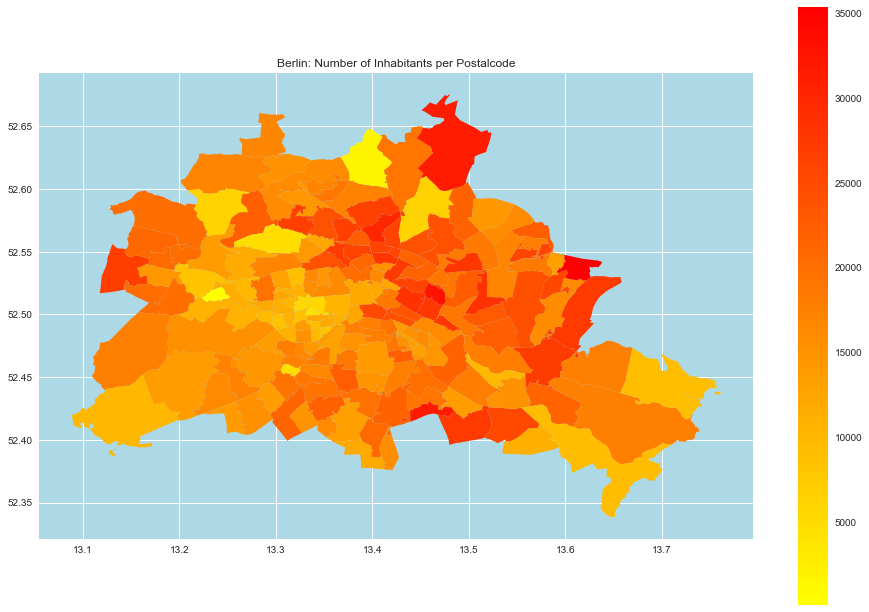

In [13]:
berlin_df = germany_df.query('ort == "Berlin"')

fig, ax = plt.subplots()

berlin_df.plot(
    ax=ax, 
    column='einwohner', 
    categorical=False, 
    legend=True, 
    cmap='autumn_r',
)

ax.set(
    title='Berlin: Number of Inhabitants per Postalcode', 
    aspect=1.3,
    facecolor='lightblue'
);

https://www.statistik-berlin-brandenburg.de/produkte/verzeichnisse/ZuordnungderBezirkezuPostleitzahlen.xls

In [14]:
berlin_plz_area_df = pd.read_excel(
    '../Data/ZuordnungderBezirkezuPostleitzahlen.xls', 
    sheet_name='plz_bez_tidy',
    dtype={'plz': str}
)

berlin_plz_area_df.head()

,plz,area
0,10115,Mitte
1,10117,Mitte
2,10119,Mitte
3,10178,Mitte
4,10179,Mitte


In [15]:
berlin_plz_area_df \
    [berlin_plz_area_df['plz'].duplicated(keep=False)] \
    .sort_values('plz')

,plz,area
2,10119,Mitte
41,10119,Pankow
4,10179,Mitte
26,10179,Friedrichshain-Kreuzberg
42,10247,Pankow
...,...,...
133,14197,Steglitz-Zehlendorf
95,14197,Charlottenburg-Wilmersdorf
165,14197,Tempelhof-Schöneberg
134,14199,Steglitz-Zehlendorf


http://insideairbnb.com/get-the-data.html

In [16]:
berlin_neighbourhoods_df = gpd.read_file('../Data/neighbourhoods.geojson')

berlin_neighbourhoods_df = berlin_neighbourhoods_df[~ berlin_neighbourhoods_df['neighbourhood_group'].isnull()]

berlin_neighbourhoods_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."


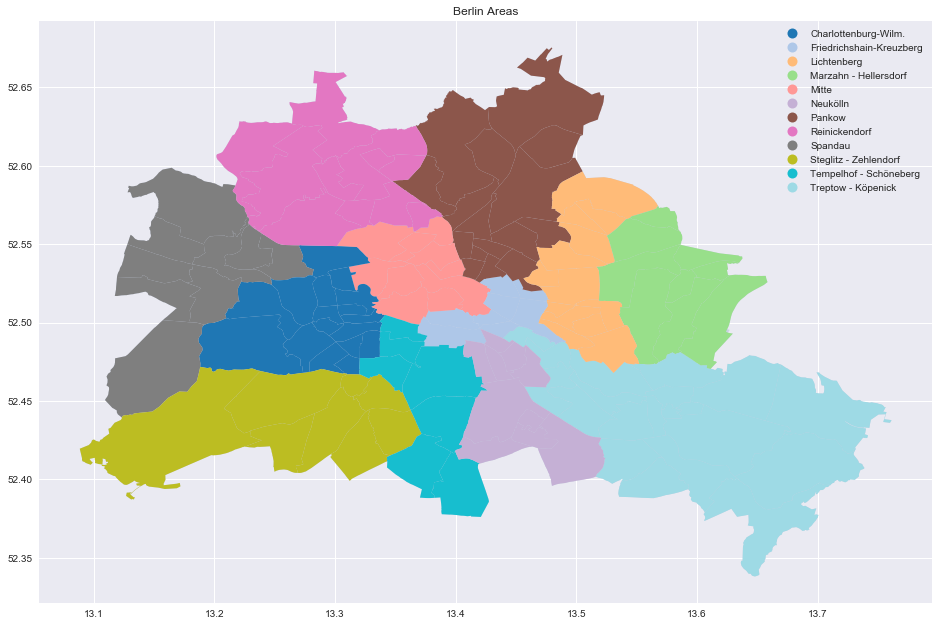

In [17]:
fig, ax = plt.subplots()

berlin_df.plot(
    ax=ax, 
    alpha=0.2
)

berlin_neighbourhoods_df.plot(
    ax=ax, 
    column='neighbourhood_group',
    categorical=True, 
    legend=True, 
    cmap='tab20',
)

ax.set(
    title='Berlin Areas', 
    aspect=1.3
);

https://daten.berlin.de/datensaetze/berliner-weihnachtsmärkte-2019

In [18]:
import requests

response = requests.get(
    'https://www.berlin.de/sen/web/service/maerkte-feste/weihnachtsmaerkte/index.php/index/all.json?q='
)

response_json = response.json()

In [19]:
berlin_maerkte_raw_df = pd.DataFrame(response_json['index'])

berlin_maerkte_raw_df.head()

,id,name,bezirk,strasse,plz_ort,veranstalter,von,bis,oeffnungszeiten,email,w3,bemerkungen,lat,lng
0,2,Weihnachtsmarkt vor dem Schloss Charlottenburg,Charlottenburg-Wilmersdorf,Spandauer Damm 20 - 24,14059 Berlin,"WeBe Veranstaltungsmanagement GmbH & Co. KG, G...",2019-11-25,2019-12-26,Mo-Do 14:00-22:00\r\nFr-So 12:00-22:00\r\n25./...,,www.wvdsc.de,"zwischen Luisenplatz und Klausenerplatz, 24.12...","52,519951","13,295946"
1,5,36. Weihnachtsmarkt an der Gedächtniskirche,Charlottenburg-Wilmersdorf,Breitscheidplatz,10789 Berlin,Arbeitsgemeinschaft City e.V.\r\nBudapester St...,2019-11-25,2020-01-05,So-Do 11:00-21:00\r\nFr-Sa 11:00-22:00\r\n24.1...,mailto:info@svbev.de,www.schaustellerverband-berlin.de,"Eintritt frei, \n31.12.: 10:00 Gottesdienst, 3...","52,504886","13,335511"
2,8,Weihnachtsmarkt in der Fußgängerzone Wilmersdo...,Charlottenburg-Wilmersdorf,Wilmersdorfer Straße,10627 Berlin,"A. Lauenburger, Tel.: 0163/495 77 62",2019-11-26,2019-12-28,täglich 11:00-21:00\r\nSo 13:00-19:00\n24.12.:...,mailto:lauenburger-pony@gmx.de,,,"52,509313","13,305994"
3,11,Weihnachten in Westend,Charlottenburg-Wilmersdorf,Preußenallee,14052 Berlin,"Family & Friends e. V.\r\nTel.: 305 55 21, Fax...",2019-12-21,2019-12-22,12:00-20:00,mailto:stadtkultur@family-and-friends-eV.de,www.family-and-friends-eV.de,Eintritt frei. Das weihnachtliche Rüsseltier i...,"52,512538","13,259213"
4,14,Weihnachtsmarkt Berlin-Grunewald des Johannisc...,Charlottenburg-Wilmersdorf,Bismarckallee 23,14193 Berlin,Johannisches Sozialwerk e.V.\r\nTel.: 89 68 80...,2019-11-29,2019-12-01,Fr 16:00-20:00\r\nSa 14:00-20:00\r\nSo 12:00-1...,,www.johannisches-sozialwerk.de,Weitere Informationen auf der Webseite,"52,48835","13,27725"


In [20]:
berlin_maerkte_df = berlin_maerkte_raw_df[['name', 'bezirk', 'plz_ort', 'lat', 'lng']]

berlin_maerkte_df = berlin_maerkte_df \
    .query('lat != ""') \
    .assign(plz = lambda x: x['plz_ort'].str.split(' ').apply(lambda x: x[0]).astype(str)) \
    .drop('plz_ort', axis=1)

berlin_maerkte_df.head()

,name,bezirk,lat,lng,plz
0,Weihnachtsmarkt vor dem Schloss Charlottenburg,Charlottenburg-Wilmersdorf,"52,519951","13,295946",14059
1,36. Weihnachtsmarkt an der Gedächtniskirche,Charlottenburg-Wilmersdorf,"52,504886","13,335511",10789
2,Weihnachtsmarkt in der Fußgängerzone Wilmersdo...,Charlottenburg-Wilmersdorf,"52,509313","13,305994",10627
3,Weihnachten in Westend,Charlottenburg-Wilmersdorf,"52,512538","13,259213",14052
4,Weihnachtsmarkt Berlin-Grunewald des Johannisc...,Charlottenburg-Wilmersdorf,"52,48835","13,27725",14193


In [21]:
berlin_maerkte_df['lat'] = berlin_maerkte_df['lat'].str.replace(',', '.').astype(float)
berlin_maerkte_df['lng'] = berlin_maerkte_df['lng'].str.replace(',', '.').astype(float)

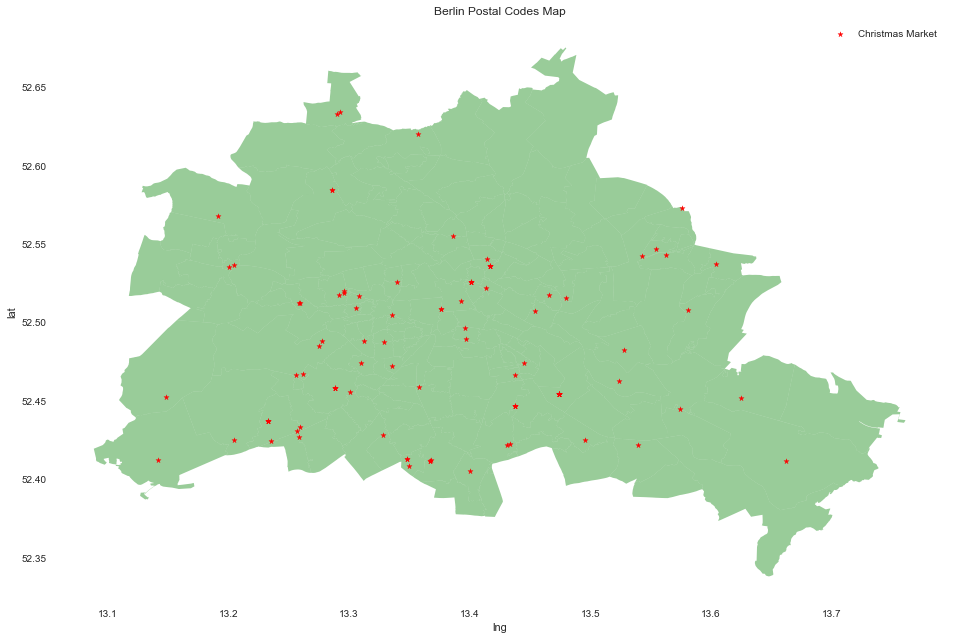

In [22]:
fig, ax = plt.subplots()

berlin_df.plot(ax=ax, color= 'green', alpha=0.4)

berlin_maerkte_df.plot(
    kind='scatter', 
    x='lng', 
    y='lat', 
    c='r', 
    marker='*',
    s=30,
    label='Christmas Market',  
    ax=ax
)

ax.set(title='Berlin Postal Codes Map', aspect=1.3, facecolor='white');

In [23]:
import mplleaflet

fig, ax = plt.subplots()

berlin_df.plot(ax=ax, color= 'green', alpha=0.4)

berlin_maerkte_df.plot(
    kind='scatter', 
    x='lng', 
    y='lat', 
    c='r', 
    marker='*',
    s=30,
    ax=ax
)

mplleaflet.display(fig=fig)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
